# **Vision Transformer ->**

![](https://raw.githubusercontent.com/uygarkurt/ViT-PyTorch/main/assets/arc.png)

### **1. Defining the Config File / Hyperparameters ->** 

In [1]:
# %%writefile Modules/_01_config.py
import torch
LEARNING_RATE = 0.01
BATCH_SIZE = 32
EPOCHS = 5
NUM_CLASSES = 26
PATCH_SIZE = 4
IMG_SIZE = 28
IN_CHANNELS = 1
NUM_HEADS = 4
HIDDEN_DIMENSION = 128
DROPOUT = 0.1
ADAM_WEIGHT_DECAY = 0.01
ADAM_BETAS = (0.9, 0.999)
ACTIVATION = "gelu"
NUM_ENCODERS = 2
EMBED_DIM = (PATCH_SIZE**2)*IN_CHANNELS 
NUM_PATCHES = (IMG_SIZE//PATCH_SIZE)**2 

device = "cuda" if torch.cuda.is_available() else "cpu"


### **2. Patch Embedding ->** 

In [2]:
# %%writefile Modules/_02_patchEmbedding.py
import torch
import torch.nn as nn
from Modules._01_config import * 

class PatchEmbedding(nn.Module):
    
    def __init__(self,
                 in_channels:int = IN_CHANNELS,
                 embed_dim:int = EMBED_DIM,
                 patch_size:int = PATCH_SIZE,
                 num_patches = NUM_PATCHES,
                 dropout = DROPOUT):
        super().__init__()
        
        self.patcher = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size), 
            nn.Flatten(2)
        ) #This moves over the image exactly the number of times patches are and in the shape of patches.
        
        self.cls_token = nn.Parameter(torch.randn(size=(1,in_channels,embed_dim)),requires_grad=True) #Shape -> [1,3,48]
        
        self.positional_embeddings = nn.Parameter(torch.randn(size=(1, num_patches+1, embed_dim)),requires_grad=True) #+1 for CLS Token
        
        self.dropout = nn.Dropout(p=dropout)
        
        
        
    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0],-1,-1) #Shape -> [1,3,48] -> [Input_shape,3,48]
        
        x= self.patcher(x).permute(0,2,1) #Shape Change -> [Input_shape,3,48] -> [Input_shape,48,3]
        
        x = torch.cat([cls_token, x], dim = 1) 

        x += self.positional_embeddings 
        
        x=self.dropout(x)
        
        return x
        


### **2. ViT Implementation ->**

In [3]:
# %%writefile Modules/_03_ViT.py
import torch
import torch.nn as nn
from Modules._01_config import *
from Modules._02_patchEmbedding import PatchEmbedding
class ViT(nn.Module):
    def __init__(self,
                 num_classes = NUM_CLASSES,
                 patch_size = PATCH_SIZE,
                 num_patches = NUM_PATCHES,
                 in_channels = IN_CHANNELS,
                 embed_dim = EMBED_DIM,
                 num_heads = NUM_HEADS,
                 hidden_dim = HIDDEN_DIMENSION,
                 num_encoders = NUM_ENCODERS,
                 activation = ACTIVATION,
                 dropout = DROPOUT):
        
        super().__init__()
        
        #Embedding Block
        self.embedding_block = PatchEmbedding(in_channels=in_channels,embed_dim=embed_dim,patch_size=patch_size,num_patches=num_patches,dropout=dropout)
        
        
        #Encoder Layer and Encoder Block -> 
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim,nhead=num_heads,dropout=dropout,activation=activation,batch_first=True, norm_first=True)
        #Batch First = True -> Telling the encoder that in out input shape the batch size comes first.
        #Norm First = True -> Layer Normalisation is used before the attention and feed-forward operations.
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer=self.encoder_layer, num_layers=num_encoders)
        
        
        #MLP (Multi Layer Perceptron) Head -> 
        self.mlp_head = nn.Sequential(
            
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )        
         
         
         
         
    def forward(self, x):
        x = self.embedding_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0, :]) #Taking the CLS Token only
        
        return x


### **3. Dataset Preparation ->**

Dataset -> A-Z Handwritten Digits

In [4]:
# %%writefile Modules/_04_dataset.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from pathlib import Path
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from Modules._01_config import *

# Define the path and read the data
data_path = Path("data")
df = pd.read_csv(data_path / "A_Z Handwritten Data.csv").astype("float32")

# Extract features and labels
X_values = df.iloc[:, 1:].values
y_values = df.iloc[:, 0].values

# Convert to appropriate numpy types
X_values = X_values.astype(np.float32)
y_values = y_values.astype(np.float32)

# Convert to tensors
X_tensor = torch.tensor(X_values, dtype=torch.float32)
y_tensor = torch.tensor(y_values, dtype=torch.int64)

# Define the transformation
transformation = transforms.Compose([
    transforms.ToPILImage(),  
    transforms.Resize((28, 28)), 
    transforms.ToTensor()
])

# Custom dataset class
class HandwrittenDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Reshape image to (1, 28, 28) from (784,)
        image = image.reshape(1, 28, 28)

        if self.transform:
            image = self.transform(image)

        return image, label

# Define class names
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'] 

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Create dataset objects
train_dataset = HandwrittenDataset(X_train, y_train, transform=transformation)
test_dataset = HandwrittenDataset(X_test, y_test, transform=transformation)

BATCH_SIZE=32
# Create dataloaders
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)


### **4. Model Training ->**

In [5]:
# %%writefile Modules/_05_training.py
import os
import torch
import torch.nn as nn
import tqdm
from timeit import default_timer as timer
from Modules._01_config import *
from Modules._02_patchEmbedding import PatchEmbedding
from Modules._03_ViT import ViT
from Modules._04_dataset import train_dataloader, test_dataloader, class_names
from torch.optim.lr_scheduler import StepLR
from pathlib import Path

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model_folder = Path("weights")
model_folder.mkdir(parents=True, exist_ok=True)
model_path = model_folder/f"ViT_{EPOCHS}_epochs.pth"

if os.path.exists(model_path):
    model = torch.load(model_path).to(device)
    print("Loaded existing model.")
else:
    model = ViT().to(device=device)
    model.apply(init_weights)
    print("Initialized new model, Set weights using Xavier Uniform.")

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=ADAM_BETAS, weight_decay=ADAM_WEIGHT_DECAY)
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)



startTime = timer()

for epoch in tqdm.tqdm(range(EPOCHS), position=0, leave=True):
    
    model.train()
    train_labels = []
    train_preds = []
    
    train_loss = 0
    
    for batch, (X, y) in enumerate(tqdm.tqdm(train_dataloader, position=0, leave=True)):
        X = X.to(device)
        y = y.to(device)
        
        y_pred = model(X)
        y_pred_label = y_pred.argmax(dim=1)
        
        train_labels.extend(y.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())
        
        loss = loss_fn(y_pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss = train_loss / len(train_dataloader)
    
    model.eval()
    val_labels = []
    val_preds = []
    
    val_loss = 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(tqdm.tqdm(test_dataloader, position=0, leave=True)):
            X = X.to(device)
            y = y.to(device)
            
            y_pred = model(X)
            y_pred_label = y_pred.argmax(dim=1)
            
            val_labels.extend(y.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())
            
            loss = loss_fn(y_pred, y)
            
            val_loss += loss.item()
            
        val_loss = val_loss / len(test_dataloader)
    
    print("-"*30)
    print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
    print(f"Test  Loss EPOCH {epoch+1}: {val_loss:.4f}")
    print(f"Train Accuracy EPOCH {epoch+1}: {sum(1 for x, y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}")
    print(f"Test Accuracy EPOCH {epoch+1}: {sum(1 for x, y in zip(val_preds, val_labels) if x == y) / len(val_labels):.4f}")
    print("-"*30)
    
    scheduler.step()

    # Save the model after each epoch
    torch.save(model, model_folder/f"ViT_{epoch+1}_epochs.pth")
    



c:\Users\gaura\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Initialized new model, Set weights using Xavier Uniform.


  0%|          | 0/9312 [00:00<?, ?it/s]c:\Users\gaura\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
100%|██████████| 2328/2328 [00:15<00:00, 148.18it/s]


------------------------------
Train Loss EPOCH 1: 2.9384
Test  Loss EPOCH 1: 2.9439
Train Accuracy EPOCH 1: 0.1524
Test Accuracy EPOCH 1: 0.1561
------------------------------


100%|██████████| 2328/2328 [00:15<00:00, 148.21it/s]


------------------------------
Train Loss EPOCH 2: 2.9378
Test  Loss EPOCH 2: 2.9381


 40%|████      | 2/5 [04:18<06:27, 129.04s/it]

Train Accuracy EPOCH 2: 0.1523
Test Accuracy EPOCH 2: 0.1561
------------------------------


100%|██████████| 2328/2328 [00:15<00:00, 146.56it/s]


------------------------------
Train Loss EPOCH 3: 2.9376
Test  Loss EPOCH 3: 2.9411
Train Accuracy EPOCH 3: 0.1526


 60%|██████    | 3/5 [06:28<04:18, 129.48s/it]

Test Accuracy EPOCH 3: 0.1561
------------------------------


100%|██████████| 2328/2328 [00:15<00:00, 146.39it/s]


------------------------------
Train Loss EPOCH 4: 2.9372
Test  Loss EPOCH 4: 2.9421


 80%|████████  | 4/5 [08:34<02:08, 128.17s/it]

Train Accuracy EPOCH 4: 0.1523
Test Accuracy EPOCH 4: 0.1561
------------------------------


100%|██████████| 2328/2328 [00:14<00:00, 155.33it/s]


------------------------------
Train Loss EPOCH 5: 2.9376
Test  Loss EPOCH 5: 2.9354


100%|██████████| 5/5 [10:42<00:00, 128.08s/it]

Train Accuracy EPOCH 5: 0.1522
Test Accuracy EPOCH 5: 0.1561
------------------------------


100%|██████████| 5/5 [10:42<00:00, 128.42s/it]


Testing -> 

C:\Users\gaura\AppData\Local\Temp\ipykernel_20412\1241588267.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)
100%|██████████| 2328/2328 [

<Figure size 640x480 with 0 Axes>

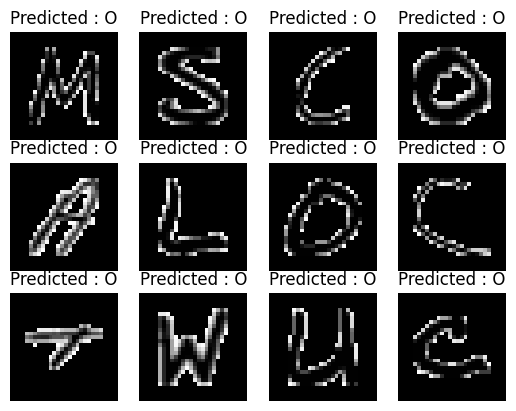

In [6]:
# %%writefile Modules/_06_testing_and_plotting.py
import torch
import torch.nn as nn
import tqdm as tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from Modules._01_config import *
from Modules._02_patchEmbedding import PatchEmbedding
from Modules._03_ViT import ViT
from Modules._04_dataset import train_dataloader, test_dataloader, class_names
from pathlib import Path

torch.cuda.empty_cache()

labels = []
ids = []
imgs = []

# Load the trained model
model_folder = Path("weights")
model_path = model_folder / f"ViT_{EPOCHS}_epochs.pth"

if not model_path.exists():
    raise FileNotFoundError(f"Model file not found: {model_path}")

model = torch.load(model_path)
model = model.to(device)
model.eval()

with torch.inference_mode():
    for batch, (X,y) in enumerate(tqdm.tqdm(test_dataloader, position=0, leave=True)):
        X=X.to(device)
        y=y.to(device)

        # ids.extend([int(i)+1 for i in y])
        
        y_pred_test = model(X)
        y_pred_test_label = y_pred_test.argmax(dim=1)
        
        imgs.extend(X.detach().cpu())
        labels.extend([int(i) for i in y_pred_test_label])
plt.figure()
f, axarr = plt.subplots(3, 4)
counter = 0
for i in range(3):
    for j in range(4):
        if counter < len(imgs):  # Check if the counter is within the range of available images

            axarr[i][j].imshow(imgs[counter].squeeze(), cmap="gray")  # Use imgs[counter] to access individual images
            axarr[i][j].set_title(f"Predicted : {class_names[labels[counter]]}")
            axarr[i][j].axis("off")

            counter += 1